In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath
from moviepy.editor import AudioFileClip, VideoFileClip, concatenate_videoclips, concatenate_audioclips

from sklearn.decomposition import PCA
from ggplot import *

Wall time: 2.4 s


In [2]:
dirpath = join(abspath(sep),'temp')
file_basename = 'trainingData'
eventFileName = join('.', file_basename+'.csv')
event_data = pd.read_csv(eventFileName, sep=',',header=0)
print len(event_data),' events loaded'

86  events loaded


In [3]:
# Compute offset of each clip in the new clips collection and add to DataFrame
offset=np.cumsum(event_data["timeToCapture"])
event_data["offset"]=offset-event_data["timeToCapture"]
# Prepare a list of labels
labels=[row["eventName"] 
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

# Concatenate video clips using ffmpeg (fast but audio gets out of sync)
This approach needs more work. In the mean time use the slower videoPy option below

In [ ]:
#for index, row in event_data.iterrows():
#    #print row['secondOffset'], row['timeToCapture']
#    if row['fileName'] == file_basename+'.wav':
#        outFileName=os.path.join(dirpath, file_basename+str(index)+'.mp4')
#        print 'Writing clip #',index,' from sec ',row['secondOffset'],' length ',row['timeToCapture']
#        ffmpeg_extract_subclip(videoFileName, row['secondOffset'], row['secondOffset']+row['timeToCapture'], targetname=outFileName)
#    else:
#        print 'Skipping ', row['fileName']

# https://trac.ffmpeg.org/wiki/Concatenate
Getting error: "IOPub data rate exceeded"?

Add the following as a parameter to 'Jupyter notebook': --NotebookApp.iopub_data_rate_limit=50000000
or upgrade Jupyter notebook to 5.1

# Concatenate video clips using videoPy


In [ ]:
%%time
clips=[]
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        videoClip = VideoFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        clips.append(videoClip)
    else:
        print 'Could not find file ', videoFileName
    
final_clip = concatenate_videoclips(clips)
final_clip.write_videofile(join(dirpath, "my_concatenation.mp4"))


In [ ]:
for clip in clips:
    del clip

# Play a video clip

In [ ]:
# Utility: Play a video clip from file starting at <offset> (in seconds) for <length> (in seconds)
def getClip(path=join(dirpath, "my_concatenation.mp4"),offset=0,length=30):
    videoClip = VideoFileClip(path).subclip(offset,offset+length)
    return videoClip

In [ ]:
def getEvent(eventNumber):
    o=int(event_data.iloc[eventNumber-1]["offset"])
    l=int(event_data.iloc[eventNumber-1]["timeToCapture"])
    return getClip(offset=o, length=l)

Play an event number from event file (first event is #1)

In [ ]:
clip = getEvent(44)  
clip.ipython_display(width=640, autoplay=True)  

Play a portion of a clip using offset and length in seconds 

In [ ]:
clip = getClip(offset=0,length=15) 
clip.ipython_display(width=640, autoplay=True)  

# Concatenate audio clips

In [4]:
%%time
clips = []
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        audioClip = AudioFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        clips.append(audioClip)
    else:
        print 'Could not find file ', videoFileName

final_clip = concatenate_audioclips(clips)
final_clip.write_audiofile(join(dirpath, "my_concatenation.mp3"))
#final_clip.write_videofile("/temp/my_concatenation.mp3")
#final_clip.ipython_display("/temp/my_concatenation.mp3",width=640, autoplay=True)
for clip in clips:
    del clip.reader
    del clip

[MoviePy] Writing audio in C:\temp\my_concatenation.mp3


100%|███████████████████████████████████████████████████████████████████████████| 28665/28665 [00:47<00:00, 608.44it/s]


[MoviePy] Done.
Wall time: 59.5 s


# Play first 30 seconds of audio clip

In [5]:
final_clip.set_end(30).ipython_display(join(dirpath, "my_concatenation.mp3"),width=640, autoplay=True)

100%|███████████████████████████████████████████████████████████████████████████████| 662/662 [00:01<00:00, 524.98it/s]


# Convert audio to WAV for ease of audio processing

In [6]:
  import subprocess
  audioFile = join(dirpath, "my_concatenation.mp3")
  subprocess.call(['ffmpeg', '-y', '-i', audioFile,
                   join(dirpath, "my_concatenation.wav")])  

0

# Perform FFT on audio in WAV format

In [7]:
 audioFile = join(dirpath, "my_concatenation.wav")  
samprate, wavdata = scipy.io.wavfile.read(audioFile)
clipDurationInSec = wavdata.shape[0]/samprate
# wavdata is (clipLengthInSec * samprate) X (2 channels: [0] is left, [1] is right )
# Sample rate is 44,100
print samprate
print wavdata.shape[0]/samprate

44100
1300


In [29]:
%%time
F = []
# Perform fft, take only positive freq. (22,050 samples) 
#  then calulate the absolute value to include both real and imaginary parts
wavdata2 = wavdata.reshape(-1, samprate,  2)
# wavdata2 = wavdata.reshape(wavdata.shape[0]/samprate, samprate,  2L)
dims = wavdata2.shape
for sec in np.arange(dims[0]):
    ch1 = scipy.fftpack.fft(wavdata2[sec,:,0])[:samprate//2] # Left channel
    ch2 = scipy.fftpack.fft(wavdata2[sec,:,1])[:samprate//2] # Right channel
    ch = np.vstack([ch1,ch2])
    F.append(ch)
F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

Wall time: 5.75 s


# Plot frequency vs. amplitude

In [9]:
def plotFrequencySpectrum(second):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 3)
    plt.plot(f,np.transpose(F_db[second-1,:,:]), alpha=0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude(in dB)')
    plt.subplot(1, 3, 2)
    plt.plot(f,np.transpose(F[second-1,:,:]), alpha=0.4)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.subplot(1, 3, 1)
    plt.plot(wavdata2[second-1,:,], alpha=0.4)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

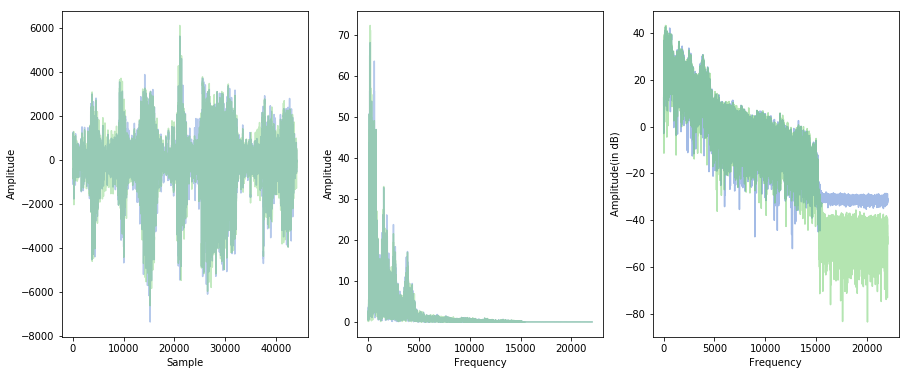

In [10]:
plotFrequencySpectrum(16)

# Dimentionality reduction: PCA

In [11]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

In [12]:
print (F.shape)
F2 = F.reshape(F.shape[0],-1)
print (F2.shape)

(1300L, 2L, 22050L)
(1300L, 44100L)


Explained variance ratio: 
[ 0.00083247  0.00082051  0.00081885  0.00081365  0.00080569  0.00080095
  0.00079336  0.0007851   0.0007826   0.00077971  0.0007729   0.00076488
  0.00075988  0.00075244  0.00075134  0.00074664  0.00073786  0.00073684
  0.00073353  0.00072847]
Explained variance ratio: 
(150L,)
Cumulative explained variance: 
[ 0.73529548  0.736116    0.73693485  0.73774849  0.73855419  0.73935513
  0.7401485   0.74093359  0.74171619  0.7424959   0.7432688   0.74403368
  0.74479357  0.74554601  0.74629735  0.74704399  0.74778185  0.7485187
  0.74925223  0.7499807 ]
PCA components: 
(150L, 44100L)
Wall time: 4.48 s


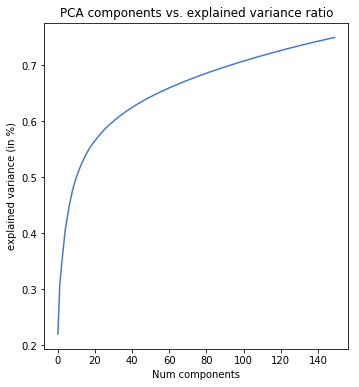

In [13]:
%%time
n_components = 150
pca_model = PCA(n_components)
pca_model.fit(F2)

print('Explained variance ratio: \n', pca_model.explained_variance_ratio_[-20:])
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_.shape)
print('Cumulative explained variance: \n', np.cumsum(pca_model.explained_variance_ratio_)[-20:])
print('PCA components: \n', pca_model.components_.shape)

plt.figure(figsize=(12, 6))
#p2 = plt.subplot(1, 2, 1)
#visualize_pca_comps_heatmap(p2, model.components_)
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('explained variance (in %)')
plt.title('PCA components vs. explained variance ratio')

In [14]:
# Apply PCA Transformation to the input to create embeddings

In [16]:
%%time
print F2.shape
t= pca_model.transform(F2)
print t.shape

(1300L, 44100L)
(1300L, 150L)
Wall time: 534 ms


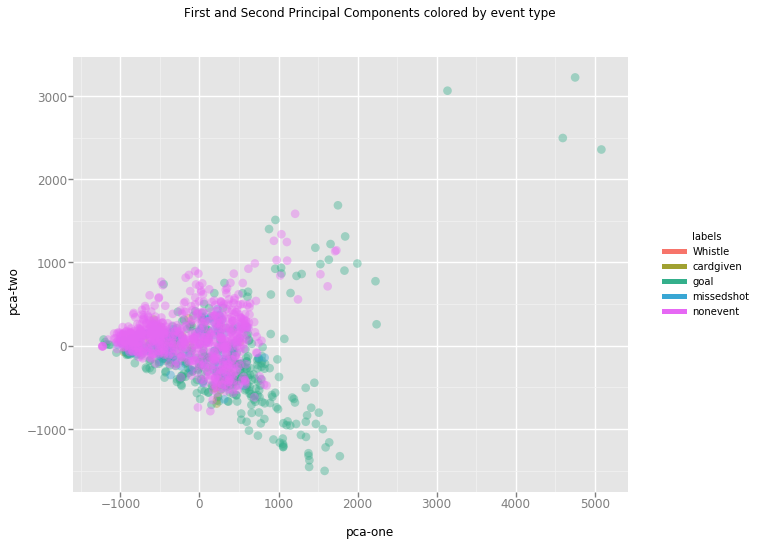

<ggplot: (53284219)>

In [18]:
df_pca = pd.DataFrame(t[:,0], columns=["pca-one"])
df_pca["pca-two"] = t[:,1]
df_pca["labels"] = labels


chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.4) \
        + ggtitle("First and Second Principal Components colored by event type")
chart

## Try tSNE
Use the reduced dimensions as were produced by PCA (to improve performance)

In [19]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=900, learning_rate=20)
tsne_results = tsne.fit_transform(t)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1300 samples in 0.008s...
[t-SNE] Computed neighbors for 1300 samples in 0.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1300
[t-SNE] Computed conditional probabilities for sample 1300 / 1300
[t-SNE] Mean sigma: 153.222494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.055901
[t-SNE] Error after 900 iterations: 1.411750
Wall time: 32.7 s


In [20]:
df_tsne = pd.DataFrame(tsne_results[:,0], columns=["x-tsne"])
df_tsne["y-tsne"] = tsne_results[:,1]
df_tsne["labels"] = labels

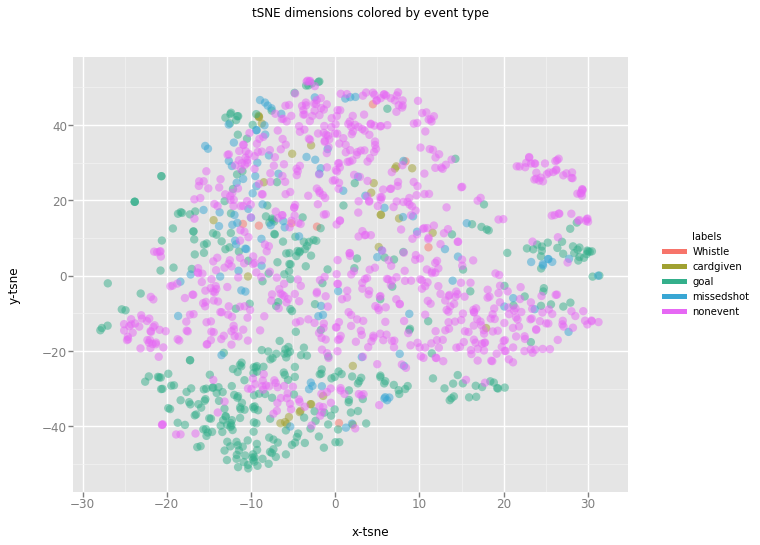

<ggplot: (122508822)>

In [21]:
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=0.5) \
        + ggtitle("tSNE dimensions colored by event type")
chart

##  Try truncated SVD

In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_components, n_iter=17, random_state=42)
svd_results = svd.fit_transform(F2)
print(svd.explained_variance_ratio_) 
print(svd.explained_variance_ratio_.sum()) 

[ 0.21391341  0.08787234  0.04031244  0.0325734   0.03161907  0.02036174
  0.01921809  0.01716978  0.01466844  0.01194554  0.01044597  0.00902898
  0.00874032  0.00782338  0.0072528   0.00680476  0.00582154  0.00567813
  0.0048962   0.00473983  0.00436201  0.00433812  0.00409698  0.00383918
  0.00371776  0.00360011  0.00352293  0.0031984   0.00303352  0.00293122
  0.00286814  0.00278145  0.00267097  0.00261396  0.00256145  0.00240299
  0.00236421  0.00233504  0.00227751  0.00217985  0.00214441  0.00212414
  0.00211309  0.0020113   0.00194398  0.00194272  0.00191824  0.00186507
  0.00180908  0.00175395  0.00170879  0.00168798  0.00166622  0.00164972
  0.00162618  0.00159123  0.00155678  0.00155022  0.0015256   0.00150103
  0.00146831  0.00145456  0.00144085  0.00143047  0.00140446  0.00138801
  0.00137519  0.00137458  0.00135417  0.00134438  0.00130547  0.00129373
  0.00128729  0.00127167  0.00126386  0.00125482  0.00123767  0.0012317
  0.00122027  0.00120202  0.00119813  0.00118494  0.

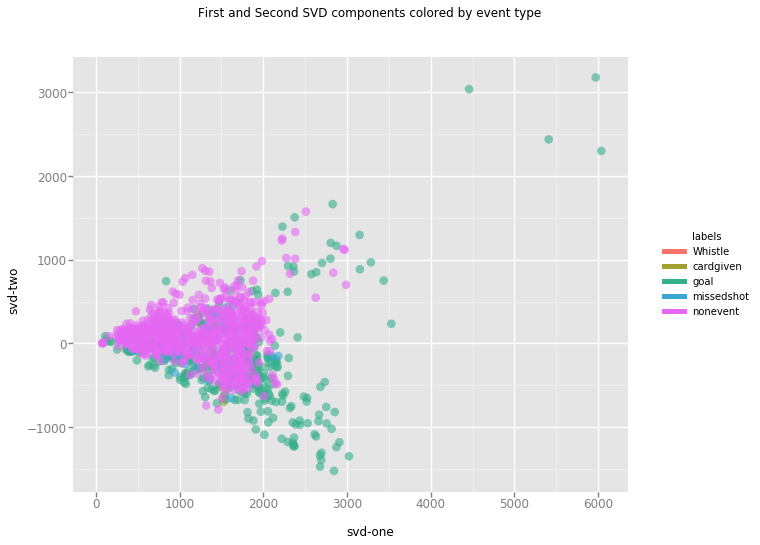

<ggplot: (78858623)>

In [23]:
df_svd = pd.DataFrame(svd_results[:,0], columns=["svd-one"])
df_svd["svd-two"] = svd_results[:,1]
df_svd["labels"] = labels


chart = ggplot( df_svd, aes(x='svd-one', y='svd-two', color='labels') ) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("First and Second SVD components colored by event type")
chart

# Classifiers

## Prepare training and test Data Sets

In [24]:
from sklearn.model_selection import train_test_split
index=np.array(np.arange(len(labels)))
data=pca_model.transform(F2)
data_train, data_test, labels_train, labels_test, index_train, index_test = train_test_split(data, labels, index, test_size=0.20, random_state=42)

## Utilities

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## KNN Classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

model = KNeighborsClassifier(n_neighbors=1)
model.fit(data_train, labels_train)
test_predicted_labels = model.predict(data_test)

wrong_prediction = (test_predicted_labels != labels_test)

print 'number of incorrect predictions:', np.sum(wrong_prediction)

number of incorrect predictions: 59


In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="macro")))   

accuracy: 77.3%
F1 score: 41.1%
Precision: 43%
Recall: : 40.5%


Confusion matrix, without normalization
[[  0   0   0   1   1]
 [  0   1   1   1   4]
 [  0   2  53   6  18]
 [  0   1   1   5  10]
 [  0   1   3   9 142]]


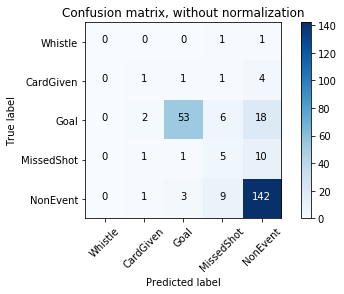

In [28]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [ ]:
l=['#'+str(index+1)+': '+row["fileName"]+','+str(row["secondOffset"])+','+str(i-row["offset"]+1)+','+row["eventName"]
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

In [ ]:
l1=index_test[(np.array(labels_test) == 'goal') & (np.array(test_predicted_labels) == 'nonevent')]

In [ ]:
l=np.array(l)

In [ ]:
l[l1]